<a href="https://colab.research.google.com/github/SaharaAli16/spatiotemporal-causality/blob/main/stcausal2024%20/methods/Causal_Inference_Simple_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Causal Effect Estimation using Observational Data

In this notebook, we will see how can we estimate the causal effect from observational data.

Here are the steps that will be involved in this notebook.
1. Load necessary libraries
2. Specify the problem and the causal graph
3. Generate data set
4. Causal effect estimation and analysis

---
# 1. Load necessary libraries
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
!pip install graphviz
!apt install libgraphviz-dev
!pip install pygraphviz

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 22 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

---
# 2. Specify the problem and the causal graph
---

"Increased levels of systolic blood pressure over time are associated with increased cardio-vascular morbidity and mortality. Summative evidence shows that exceeding the recommendations for 24-hour dietary sodium (SD) intake in grams (gr) is associated with increased levels of systolic blood pressure (BP) in mmHg. Furthermore, with advancing age, the kidney undergoes several anatomical and physiological changes that limit the adaptive mechanism responsible for maintaining the composition and volume of the extracellular fluid. These include a decline in glomerular filtration rate and the impaired ability to maintain water and sodium homeostasis in response to dietary and environmental changes. Likewise, age is associated with structural changes in the arteries and thus BP. Age is a common cause of both high SBP and impaired sodium homeostasis. Thus age acts as a confounder for the association between sodium intake and BP."

"However, high levels of 24-hour excretion of urinary protein (proteinuria) are caused by sustained high BP and increased 24-hour dietary sodium intake. Therefore, proteinuria (PR) acts as a collider via the path SD -> PR <- BP."




Reference: https://pubmed.ncbi.nlm.nih.gov/30561628/
Link: https://watzilei.com/shiny/collider/

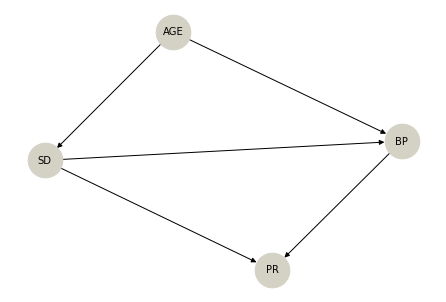

In [ ]:
## Build the causal graph and display it
# A directed graph
graph = nx.DiGraph()
# Add edges
graph.add_edge("SD","BP")
graph.add_edge("SD","PR")
graph.add_edge("BP","PR")
graph.add_edge("AGE","SD")
graph.add_edge("AGE","BP")

# Set layout and draw the causal graph
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph), node_size=1200, font_size=10, node_color='#d4d1c5', with_labels=True)

---
# 3. Generate data set
---
"The data generation for the simulation is based on the structural relationship between the variables depicted on the Directed Acyclic Graph. We simulated 24-hour excretion of urinary protein as a function of age, SBP, and sodium intake. We assured that the range of values of the simulated data was biologically plausible and as close to reality as possible"

Reference: https://pubmed.ncbi.nlm.nih.gov/30561628/
Link: https://watzilei.com/shiny/collider/

---
3.1. Define a function to generate data
---

In [ ]:
def generateData(n=1000, seed=0, beta=1.05, alpha1=0.4, alpha2=0.3):
    # Seed random number generator
    np.random.seed(seed)

    # generate age with mean 65 years and standard deviation 5 years
    # age = f(U_age)
    age = np.random.normal(65, 5, n)

    # generate sodium level based on age
    # sodium = f(age, U_sodium)
    sodium = age / 18 + np.random.normal(size = n)

    # Treatment threshold
    # if sodium < 3.5 then treatment = 0
    # if sodium >= 3.5 then treatment = 1
    binaryTreatmentThreshold=3.5
    #sodium = (sodium > binaryTreatmentThreshold).astype(int)

    # generate blood pressure based on sodium and age.
    # bloodPressure = f(sodium, age, U_bloodPressure)
    bloodPressure = beta * sodium + 2 * age + np.random.normal(size = n)

    # generate proteinuria based on sodium and blood pressure
    # proteinuria = f(sodium, bloodPressure, U_proteinuria)
    proteinuria = alpha1 * sodium + alpha2 * bloodPressure + np.random.normal(size = n)

    # combine all variables and return a dataframe
    return pd.DataFrame({'sodium':sodium, 'age':age, 'proteinuria':proteinuria,'bloodPressure':bloodPressure})

---
3.2 Generate data set
---


In [ ]:
dataset = generateData(n=10000, beta=1.05, alpha1=0.4, alpha2=0.3)
dataset.head()

,sodium,age,proteinuria,bloodPressure
0,3.899009,73.820262,47.550194,152.064528
1,2.889035,67.000786,42.570771,137.034579
2,5.616583,69.893690,46.701630,146.502908
3,4.424230,76.204466,49.149768,157.482588
4,3.952067,74.337790,47.330976,150.321303


---
4.1 Causal effect estimation: Define a function for causal effect estimation
---

In [ ]:
# An approach to causal effect estimation
def causalEffectEstimation(data, xColumns, zColumns, yColumns, model = RandomForestClassifier(n_estimators=10)):
    # separate data into treatment, adjustment set, outcome
    # treatment, X
    trainX = data[xColumns]
    # adjustment set, Z
    trainZ = data[zColumns]
    # outcome, Y
    trainY = data[yColumns]

    # merge treatment, X and adjustment, Z
    trainXZ = pd.concat([trainX, trainZ], axis = 1)

    # we fit an ML model
    model.fit(trainXZ, trainY)

    ## Causal effect estimation

    # do(X=0): Set sodium (SD), X = 0.  That is, SD < 3.5
    testXZPlacebo = trainXZ.copy()
    testXZPlacebo[xColumns] = 0
    # do(X=1): Set sodium (SD), X = 1.  That is, SD >= 3.5
    testXZTreatment = trainXZ.copy()
    testXZTreatment[xColumns] = 1

    # Estimate P(y|do(X=0))
    placeboEstimate = np.mean(model.predict(testXZPlacebo))
    # Estimate P(y|do(X=1))
    treatmentEstimate = np.mean(model.predict(testXZTreatment))

    # Estimate the causal effect: P(y|do(X=1)) - P(y|do(X=0))
    causalEffect = treatmentEstimate - placeboEstimate

    # Print results:
    print('Placebo estimate:' + str(placeboEstimate))
    print('Treatment estimate:' + str(treatmentEstimate))
    print('Causal effect:' + str(causalEffect))

---
4.2 Results and analysis
---

In [ ]:
# Adjust both age and proteinuria
xColumns = ['sodium']
zColumns = ['age', 'proteinuria']
yColumns = ['bloodPressure']
causalEffectEstimation(dataset, xColumns, zColumns, yColumns, LinearRegression())

Placebo estimate:130.51523845236562
Treatment estimate:131.37025845224255
Causal effect:0.8550199998769301


In [ ]:
# adjust nothing
xColumns = ['sodium']
zColumns = []
yColumns = ['bloodPressure']
causalEffectEstimation(dataset, xColumns, zColumns, yColumns, LinearRegression())

Placebo estimate:120.77742216788377
Treatment estimate:124.3246937003098
Causal effect:3.5472715324260236


In [ ]:
# adjust age
xColumns = ['sodium']
zColumns = ['age']
yColumns = ['bloodPressure']
causalEffectEstimation(dataset, xColumns, zColumns, yColumns, LinearRegression())

Placebo estimate:129.78610272729128
Treatment estimate:130.84270968628923
Causal effect:1.0566069589979463
